-- 只包括输入、输入。一个潜艇目标 

-- 背景噪声为随机点


### 地理坐标系转为地心坐标系（x,y,z）.
-- WGS-84坐标,也叫经纬高坐标系(经度(longitude)，纬度(latitude)和高度(altitude)LLA坐标系），全球地理坐标系、大地坐标系。是最为广泛应用的一个地球坐标系，它给出一点的大地纬度、大地经度和大地高程而更加直观地告诉我们该点在地球中的位置，故又被称作纬经高坐标系。

-- 地心坐标系（x,y,z），其原点为地球的质心，x轴延伸通过本初子午线（0度经度）和赤道（0deglatitude）的交点。 z轴延伸通过的北极（即，与地球旋转轴重合）。 y轴完成右手坐标系，穿过赤道和90度经度。度量衡是米。

In [29]:
# 将地理坐标系EPSG:4326转为 地心坐标系EPSG:4979。空间直角坐标系，地心为原点，度量衡是米
from geographiclib.geodesic import Geodesic
from pyproj import Transformer

def lla_to_xyz(lat, lon, alt):
    transprojr = Transformer.from_crs(
        "EPSG:4326",
        {"proj": 'geocent', "ellps": 'WGS84', "datum": 'WGS84'}, always_xy=True)
    x, y, z = transprojr.transform(lon, lat, alt, radians=False)
    return x, y, z

In [30]:
# (纬, 经, 高) --> (x, y, z)
uav_lla = (18.01944, 112.5194, 300)
sub_lla = (18.01944, 112.5184, -100)
boa_lla = (18.025, 112.5104, 0)

uav_x, uav_y, uav_z = lla_to_xyz(uav_lla[0], uav_lla[1], uav_lla[2])
print(uav_x, uav_y, uav_z)

sub_x, sub_y, sub_z = lla_to_xyz(sub_lla[0], sub_lla[1], sub_lla[2])
print(sub_x, sub_y, sub_z)

boa_x, boa_y, boa_z = lla_to_xyz(boa_lla[0], boa_lla[1], boa_lla[2])
print(boa_x, boa_y, boa_z)

-2323840.5772230513 5604878.959308245 1960523.4837026002
-2323597.075056343 5604568.137995765 1960399.747837618
-2322778.0228812085 5604804.483291508 1961015.8733274625


### 读取潜艇形状仿真数据与高光谱背景数据

In [31]:
#读取潜艇csv文件
import pandas as pd
import numpy as np
df = pd.read_csv('df_im_sub.csv')
im_sub = np.array(df)

In [32]:
df_ = pd.read_csv('df_noise.csv')
noi = np.array(df_)

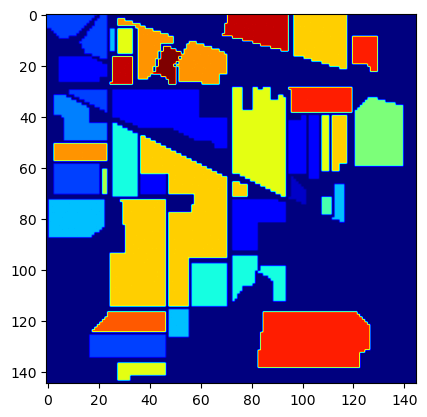

In [33]:
#可视化
import matplotlib.pyplot as plt
plt.imshow(noi,cmap='jet')
# plt.figure()
# plt.show()

### 计算潜艇和无人机的相对位置

In [34]:
# 三维空间中两点之间的距离
import math
def distance_3d(x1, y1, z1, x2, y2, z2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
L_sub_uav = distance_3d(sub_x, sub_y, sub_z, uav_x, uav_y, uav_z)
L_sub_uav

413.77984214650616

In [35]:
#通过斜边（两点距离）和高度（无人机和潜艇的相对高度）计算潜艇到视野中心点的距离
d = math.sqrt(L_sub_uav**2 -(uav_lla[2] - sub_lla[2])**2)
d

105.89503183241197

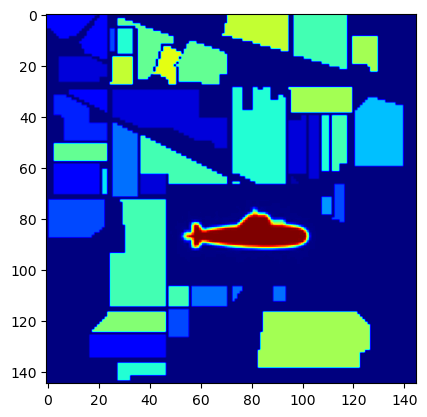

<Figure size 640x480 with 0 Axes>

In [36]:
#判断潜艇到视野中心点的距离是否超出探测范围(幅宽半径)
import matplotlib.pyplot as plt
import random
import numpy as np
#定义探测范围（以彩虹5无人机飞行高度5000m为例，探测幅宽为2000m，即d最大为1000m）
D = 1000

#判断距离d是否超出探测范围。如果超出范围，输出提示；否则将潜艇嵌入指定位置并进行可视化
if d > D:
    print('超出探测范围')
else:#将潜艇在该位置嵌入
    #放大背景噪声：noise*10
    noi = noi*10
    #将潜艇插入该位置
    noi[100+int(d/13.8)-40:100+int(d/13.8), 100+int(d/13.8)-60:100+int(d/13.8)] = im_sub

    plt.imshow(noi,cmap='jet')
    plt.figure()
    plt.show()

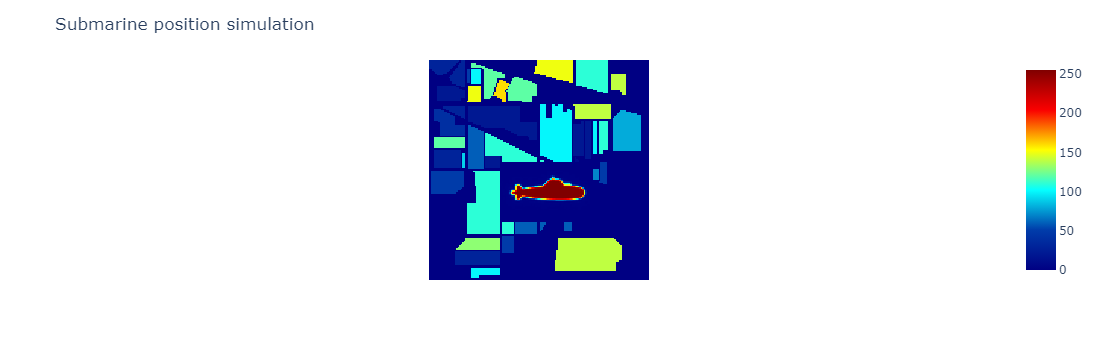

In [38]:
import plotly.express as px
cls = px.imshow(noi, color_continuous_scale='jet')
cls.update_layout(title='Submarine position simulation', coloraxis_showscale=True)
cls.update_xaxes(showticklabels=False)
cls.update_yaxes(showticklabels=False)
cls.show()

### 返回潜艇位置信息
-- 接收到的位置信息，添加高斯噪声后返回

In [88]:
sub_lla = (18.01944, 112.5184, -100)

In [89]:
import random
def gauss_noisy(x, y, mu=0, sigma=0.1):
    """
    对输入数据加入高斯噪声
    :param x: x轴数据
    :param y: y轴数据
    :return:
    """
    x += random.gauss(mu, sigma)
    y += random.gauss(mu, sigma)
    # z += random.gauss(mu, sigma)
    return x, y

In [90]:
gauss_noisy(sub_lla[0], sub_lla[1])

(18.105931665436582, 112.59314704975043)